# Project 2 - Used Car Price Estimation

Datset: https://www.kaggle.com/datasets/frederickferguson/hair-salon-no-show-data-set


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
# Load the dataset
df = pd.read_csv('../data/hair_salon_no_show_wrangled_df.csv')

# Display the first few rows of the dataset
df.head()

Unnamed: 0   book_tod   book_dow book_category book_staff last_category  \
0           0  afternoon  Wednesday         STYLE         JJ           NaN   
1           1    morning  Wednesday         COLOR     JOANNE           NaN   
2           2        NaN  Wednesday         STYLE         JJ         COLOR   
3           3  afternoon   Thursday         STYLE      KELLY           NaN   
4           4    evening   Saturday         STYLE      KELLY         STYLE   

  last_staff  last_day_services  last_receipt_tot   last_dow  ...  \
0        NaN                  0               0.0        NaN  ...   
1        NaN                  0               0.0        NaN  ...   
2     JOANNE                  2             262.0  Wednesday  ...   
3        NaN                  0               0.0        NaN  ...   
4      KELLY                  1              35.0   Thursday  ...   

  last_prod_flag  last_cumrev  last_cumbook  last_cumstyle  last_cumcolor  \
0              0            0             0              0              0   
1              0            0             0              0              0   
2              1          262             2              1              1   
3              0            0             0              0              0   
4              0           35             1              1              0   

   last_cumprod  last_cumcancel  last_cumnoshow  noshow  recency  
0             0               0               0       0        0  
1             0               0               0       0        0  
2             2               0               0       0       35  
3             0               0               0       0        0  
4             0               0               0       0        9  

[5 rows x 22 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1952 non-null   int64  
 1   book_tod           1717 non-null   object 
 2   book_dow           1952 non-null   object 
 3   book_category      1952 non-null   object 
 4   book_staff         1952 non-null   object 
 5   last_category      1003 non-null   object 
 6   last_staff         1003 non-null   object 
 7   last_day_services  1952 non-null   int64  
 8   last_receipt_tot   1952 non-null   float64
 9   last_dow           1003 non-null   object 
 10  last_tod           858 non-null    object 
 11  last_noshow        1952 non-null   int64  
 12  last_prod_flag     1952 non-null   int64  
 13  last_cumrev        1952 non-null   int64  
 14  last_cumbook       1952 non-null   int64  
 15  last_cumstyle      1952 non-null   int64  
 16  last_cumcolor      1952 

In [4]:
# Fill missing values in 'book_tod' using forward fill
df['book_tod'].fillna(method='ffill', inplace=True)

# Fill missing values in 'last_category' with 'MISC'
df['last_category'].fillna('MISC', inplace=True)

# Fill missing values in 'last_staff' with corresponding 'book_staff'
df['last_staff'].fillna(df['book_staff'], inplace=True)

# Fill missing values in 'last_dow' and 'last_tod' with a new label 'Unknown'
df['last_dow'].fillna('Unknown', inplace=True)
df['last_tod'].fillna('Unknown', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1952 non-null   int64  
 1   book_tod           1952 non-null   object 
 2   book_dow           1952 non-null   object 
 3   book_category      1952 non-null   object 
 4   book_staff         1952 non-null   object 
 5   last_category      1952 non-null   object 
 6   last_staff         1952 non-null   object 
 7   last_day_services  1952 non-null   int64  
 8   last_receipt_tot   1952 non-null   float64
 9   last_dow           1952 non-null   object 
 10  last_tod           1952 non-null   object 
 11  last_noshow        1952 non-null   int64  
 12  last_prod_flag     1952 non-null   int64  
 13  last_cumrev        1952 non-null   int64  
 14  last_cumbook       1952 non-null   int64  
 15  last_cumstyle      1952 non-null   int64  
 16  last_cumcolor      1952 

C:\Users\flag8\AppData\Local\Temp\ipykernel_45452\3749925886.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['book_tod'].fillna(method='ffill', inplace=True)
C:\Users\flag8\AppData\Local\Temp\ipykernel_45452\3749925886.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['book_tod'].fillna(method='ffill', inplace=True)
C:\Users\flag8\AppData\Local\Temp\ipykernel_45452\3749925886.py:5: FutureWarning: A value is trying to be set on 

In [5]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['book_tod', 'book_dow', 'book_category', 'book_staff', 'last_category', 'last_staff', 'last_dow', 'last_tod']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Convert data types to numeric
df = df.apply(pd.to_numeric)

# Display the first few rows of the processed dataset
df.head()

Unnamed: 0  book_tod  book_dow  book_category  book_staff  last_category  \
0           0         0         6              2           2              1   
1           1         2         6              0           3              1   
2           2         2         6              2           2              0   
3           3         0         4              2           4              1   
4           4         1         2              2           4              2   

   last_staff  last_day_services  last_receipt_tot  last_dow  ...  \
0           2                  0               0.0         6  ...   
1           3                  0               0.0         6  ...   
2           3                  2             262.0         7  ...   
3           4                  0               0.0         6  ...   
4           4                  1              35.0         4  ...   

   last_prod_flag  last_cumrev  last_cumbook  last_cumstyle  last_cumcolor  \
0               0            0             0              0              0   
1               0            0             0              0              0   
2               1          262             2              1              1   
3               0            0             0              0              0   
4               0           35             1              1              0   

   last_cumprod  last_cumcancel  last_cumnoshow  noshow  recency  
0             0               0               0       0        0  
1             0               0               0       0        0  
2             2               0               0       0       35  
3             0               0               0       0        0  
4             0               0               0       0        9  

[5 rows x 22 columns]

In [6]:
# Display basic statistics
df.describe()

Unnamed: 0     book_tod     book_dow  book_category   book_staff  \
count  1952.000000  1952.000000  1952.000000    1952.000000  1952.000000   
mean    975.500000     0.888832     3.236680       1.606557     2.320697   
std     563.638182     0.856392     2.091286       0.771027     1.610964   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     487.750000     0.000000     2.000000       2.000000     2.000000   
50%     975.500000     1.000000     4.000000       2.000000     2.000000   
75%    1463.250000     2.000000     5.000000       2.000000     4.000000   
max    1951.000000     2.000000     6.000000       2.000000     6.000000   

       last_category   last_staff  last_day_services  last_receipt_tot  \
count    1952.000000  1952.000000        1952.000000       1952.000000   
mean        1.255635     2.432889           0.545082         35.782679   
std         0.652024     1.636840           0.658514         59.371877   
min         0.000000     0.000000           0.000000          0.000000   
25%         1.000000     2.000000           0.000000          0.000000   
50%         1.000000     2.000000           0.000000          0.000000   
75%         2.000000     4.000000           1.000000         60.000000   
max         2.000000     6.000000           3.000000        382.800000   

          last_dow  ...  last_prod_flag  last_cumrev  last_cumbook  \
count  1952.000000  ...     1952.000000  1952.000000   1952.000000   
mean      4.679303  ...        0.114242   111.258197      1.906762   
std       2.118388  ...        0.318186   207.927702      3.315854   
min       0.000000  ...        0.000000     0.000000      0.000000   
25%       4.000000  ...        0.000000     0.000000      0.000000   
50%       6.000000  ...        0.000000     0.000000      1.000000   
75%       6.000000  ...        0.000000   132.000000      2.000000   
max       7.000000  ...        1.000000  1276.000000     20.000000   

       last_cumstyle  last_cumcolor  last_cumprod  last_cumcancel  \
count    1952.000000    1952.000000   1952.000000     1952.000000   
mean        1.520492       0.325307      0.487193        0.280225   
std         2.756585       0.827646      1.261275        0.853646   
min         0.000000       0.000000      0.000000        0.000000   
25%         0.000000       0.000000      0.000000        0.000000   
50%         0.000000       0.000000      0.000000        0.000000   
75%         2.000000       0.000000      0.000000        0.000000   
max        18.000000       7.000000     11.000000        8.000000   

       last_cumnoshow       noshow      recency  
count     1952.000000  1952.000000  1952.000000  
mean         0.422643     0.114754    14.402152  
std          1.319786     0.318807    21.079495  
min          0.000000     0.000000     0.000000  
25%          0.000000     0.000000     0.000000  
50%          0.000000     0.000000     1.000000  
75%          0.000000     0.000000    27.000000  
max          9.000000     1.000000   133.000000  

[8 rows x 22 columns]

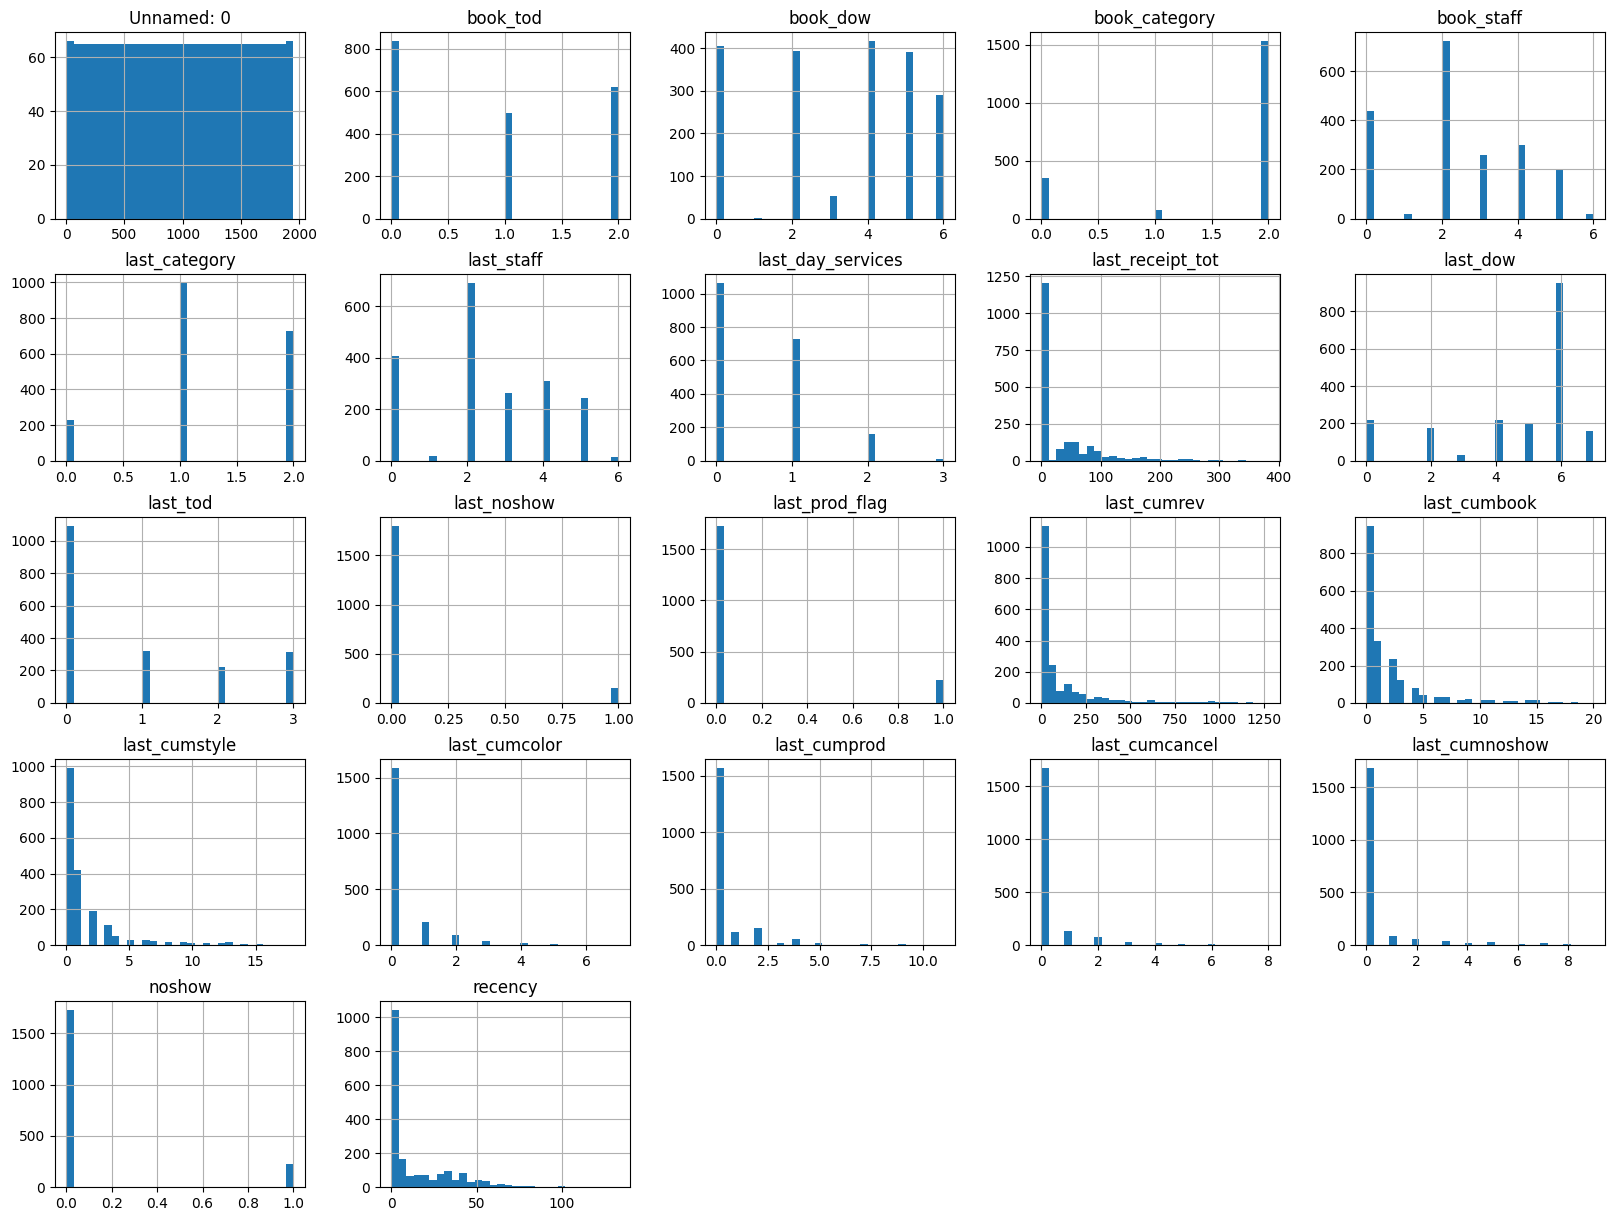

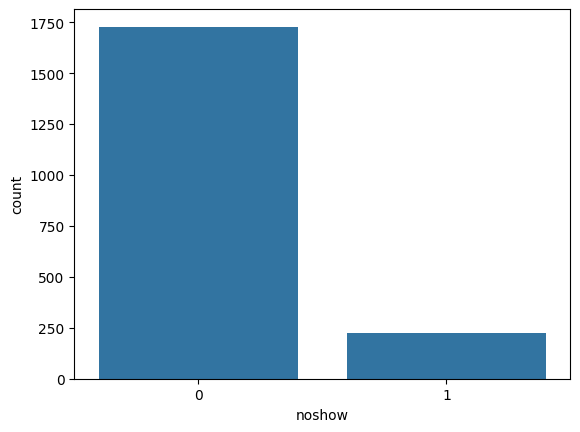

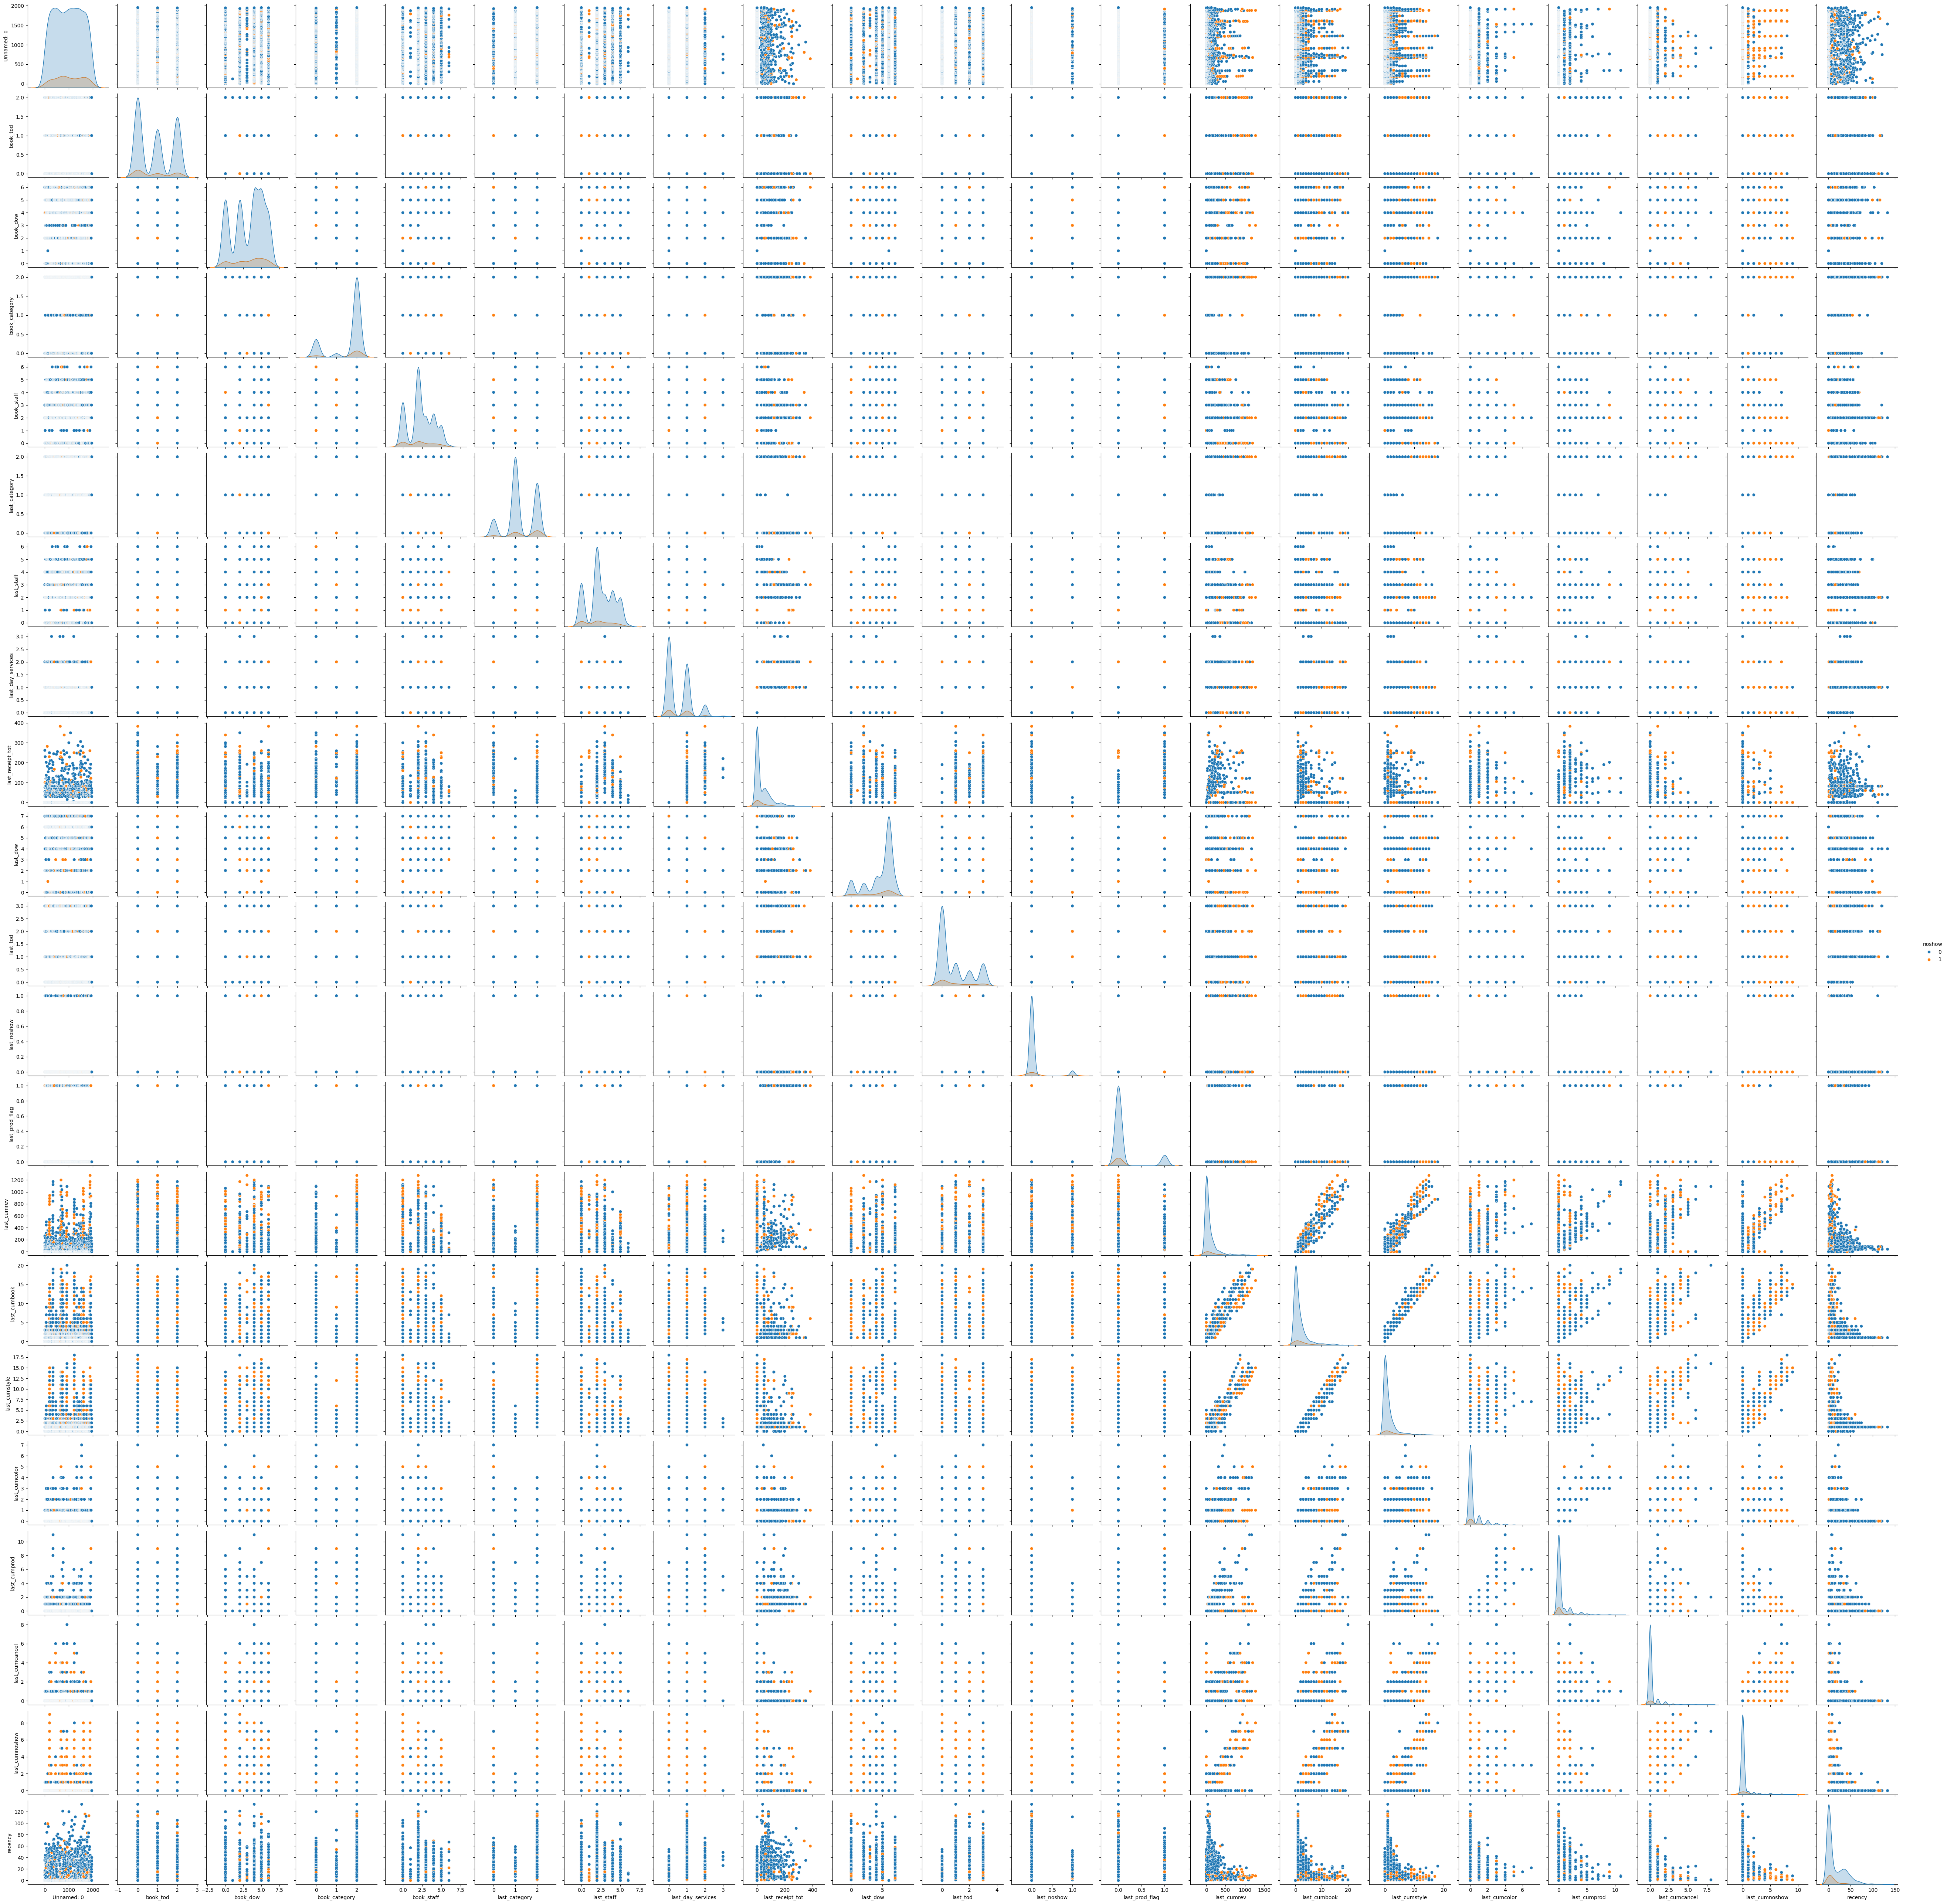

In [7]:
# Visualize the distribution of each variable
df.hist(bins=30, figsize=(20, 15))
plt.show()

# Analyze the relationship between the target variable 'noshow' and other variables
sns.countplot(x='noshow', data=df)
plt.show()

sns.pairplot(df, hue='noshow', diag_kind='kde')
plt.show()

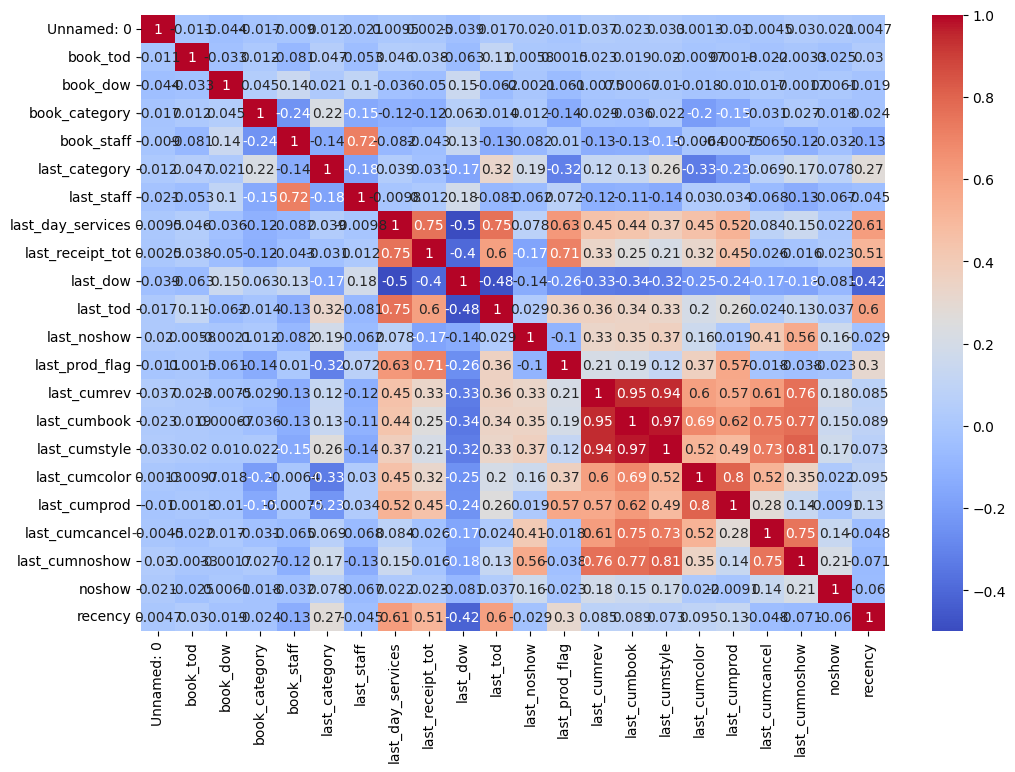

noshow               1.000000
last_cumnoshow       0.214799
last_cumrev          0.184577
last_cumstyle        0.174626
last_noshow          0.162844
last_cumbook         0.149282
last_cumcancel       0.136035
last_category        0.078258
last_tod             0.037306
last_receipt_tot     0.023062
last_day_services    0.021733
last_cumcolor        0.021623
Unnamed: 0           0.021313
book_dow             0.006138
last_cumprod        -0.009090
book_category       -0.018493
last_prod_flag      -0.023193
book_tod            -0.024590
book_staff          -0.031772
recency             -0.059878
last_staff          -0.066759
last_dow            -0.080573
Name: noshow, dtype: float64

In [9]:
# Compute the correlation matrix
corr_matrix = df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Identify key variables
corr_matrix['noshow'].sort_values(ascending=False)

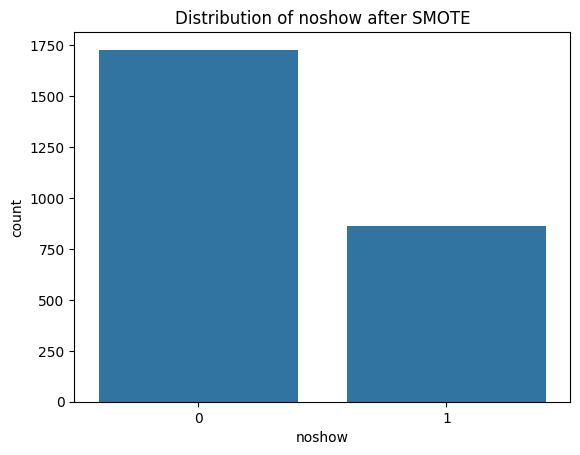

In [10]:
# Separate features and target
X = df.drop(columns=['noshow'])
y = df['noshow']

# Apply SMOTE to address class imbalance with a sampling strategy
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # Adjust the ratio here
X_resampled, y_resampled = smote.fit_resample(X, y)

# Visualize the distribution of the target variable (after SMOTE)
sns.countplot(x=y_resampled)
plt.title("Distribution of noshow after SMOTE")
plt.show()

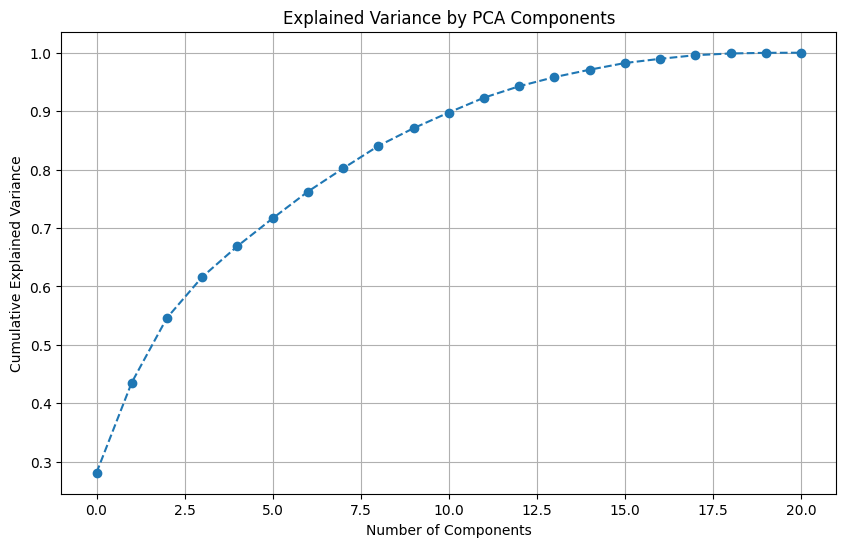

Number of components explaining 90% of the variance: 12


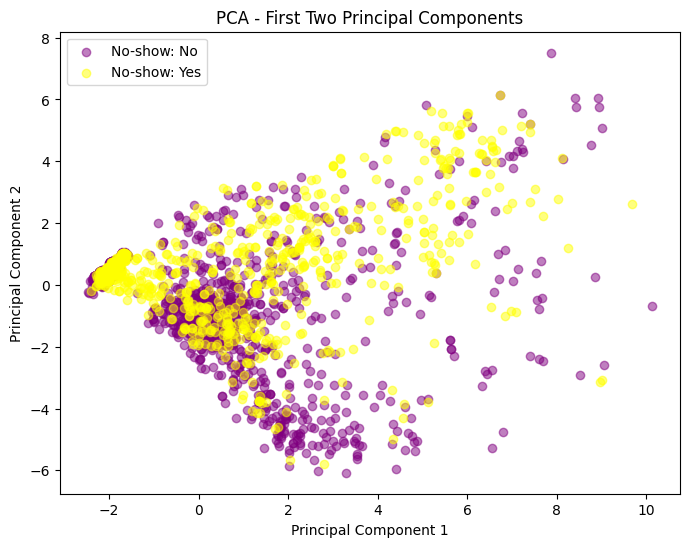

In [14]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Perform PCA and determine the amount of variance explained by each component
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Select the number of components that explain at least 90% of the variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.90) + 1
print(f"Number of components explaining 90% of the variance: {n_components}")

# Perform PCA with the selected number of components
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(X_scaled)

# Visualize the first two principal components
plt.figure(figsize=(8, 6))
colors = {0: 'purple', 1: 'yellow'}
labels = {0: 'No-show: No', 1: 'No-show: Yes'}

pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(n_components)])
pca_df = pd.concat([pca_df, pd.DataFrame(y_resampled, columns=['noshow'])], axis=1)

for label in pca_df['noshow'].unique():
    subset = pca_df[pca_df['noshow'] == label]
    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'],
                c=colors[label], label=labels[label], alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA - First Two Principal Components')
plt.legend()
plt.show()

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(principal_components, y_resampled, test_size=0.2, random_state=42)

In [17]:
# Method 1: XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

XGBoost Classifier:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       357
           1       0.76      0.71      0.73       162

    accuracy                           0.84       519
   macro avg       0.81      0.80      0.81       519
weighted avg       0.84      0.84      0.84       519



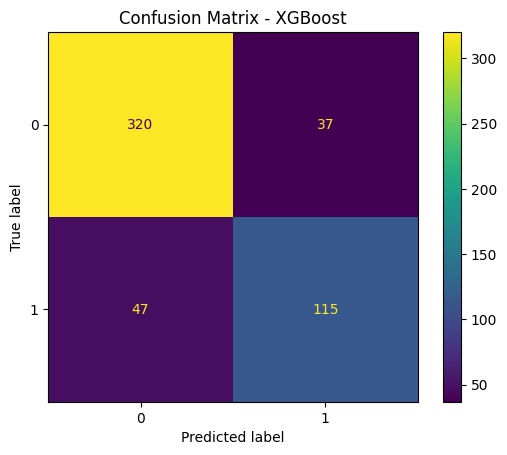

In [18]:
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Classifier:")
print(classification_report(y_test, y_pred_xgb))

# Plot confusion matrix for XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_model.classes_)
disp_xgb.plot(cmap='viridis')
plt.title('Confusion Matrix - XGBoost')
plt.show()

In [19]:
# Method 2: Support Vector Classifier (SVC)
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

Support Vector Classifier (SVC):
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       357
           1       0.76      0.55      0.64       162

    accuracy                           0.81       519
   macro avg       0.79      0.74      0.75       519
weighted avg       0.80      0.81      0.80       519



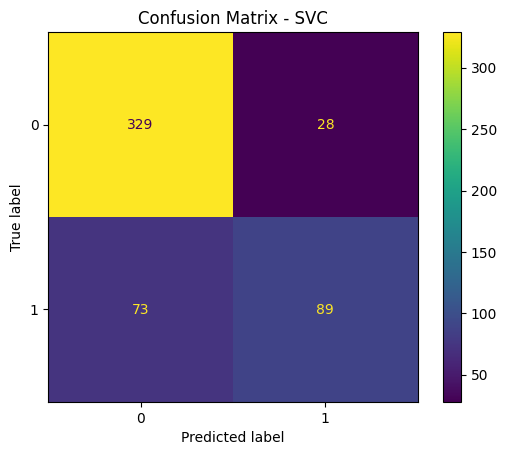

In [20]:
print("Support Vector Classifier (SVC):")
print(classification_report(y_test, y_pred_svc))

# Plot confusion matrix for SVC
cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=svc_model.classes_)
disp_svc.plot(cmap='viridis')
plt.title('Confusion Matrix - SVC')
plt.show()

In [21]:
# Method 3: Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       357
           1       0.77      0.69      0.73       162

    accuracy                           0.84       519
   macro avg       0.82      0.80      0.81       519
weighted avg       0.83      0.84      0.84       519



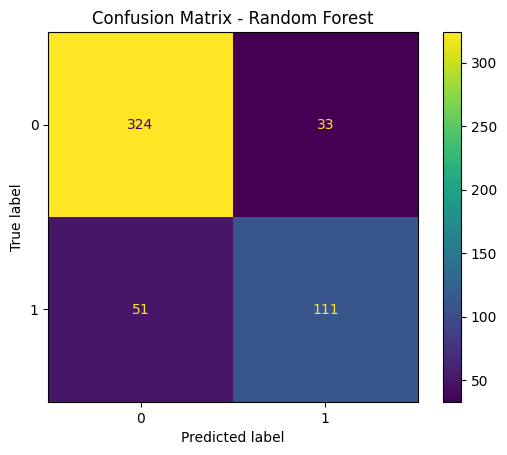

In [22]:
print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

# Plot confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_model.classes_)
disp_rf.plot(cmap='viridis')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [25]:
# Build the neural network model
model = Sequential()
model.add(Dense(64, input_dim=n_components, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)

Epoch 1/200


c:\Users\flag8\Work\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5967 - loss: 0.7206 - val_accuracy: 0.6699 - val_loss: 0.6180
Epoch 2/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6635 - loss: 0.6258 - val_accuracy: 0.7157 - val_loss: 0.5837
Epoch 3/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.6175 - val_accuracy: 0.7277 - val_loss: 0.5736
Epoch 4/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7147 - loss: 0.5688 - val_accuracy: 0.7373 - val_loss: 0.5660
Epoch 5/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7013 - loss: 0.5932 - val_accuracy: 0.7373 - val_loss: 0.5633
Epoch 6/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6948 - loss: 0.5881 - val_accuracy: 0.7349 - val_loss: 0.5608
Epoch 7/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7291 - loss: 0.5598 - val_accuracy: 0.7325 - val_loss: 0.5572
Epoch 8/200
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6956 - loss: 0.5831 - val_accuracy: 0.7349 - val_loss: 0.5

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Neural Network Classifier:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       357
           1       0.80      0.51      0.62       162

    accuracy                           0.81       519
   macro avg       0.81      0.73      0.75       519
weighted avg       0.81      0.81      0.79       519



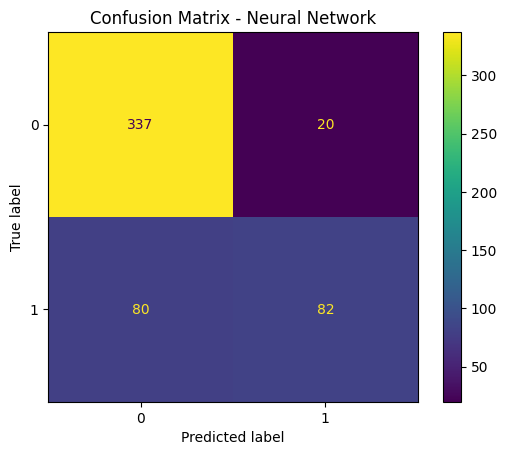

In [26]:
# Evaluate the model
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

print("Neural Network Classifier:")
print(classification_report(y_test, y_pred_nn))

# Plot confusion matrix for Neural Network
cm_nn = confusion_matrix(y_test, y_pred_nn)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=[0, 1])
disp_nn.plot(cmap='viridis')
plt.title('Confusion Matrix - Neural Network')
plt.show()